<a href="https://colab.research.google.com/github/ftaheri/neural_networks/blob/main/housePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import activations
import cv2
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
import zipfile
import matplotlib.image as mpimg
from tensorflow import keras
from skimage import exposure,transform
from skimage.util import random_noise
import random
from sklearn import metrics
import math
%matplotlib inline

# Loading

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls "/gdrive/My Drive/Proj2_data"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
data1  data2


In [ ]:
!ls "/gdrive/My Drive/Proj2_data/data2"

desc.csv  pics.zip


pictures are in 4 different size:                            
311 x 415 x 3  (most of them)                     
311 x 415 x 4   (4)->ignore                     
350 x 350 x 3   ->resize                      
350 x 525 x 4   (7)->ignore                        

resize 350x350 and 311x415

we'll ignore rgba pictures

In [ ]:
ignored_indices=[]
input_data=pd.read_csv('/gdrive/My Drive/Proj2_data/data2/desc.csv')
input=[]
i=0
with zipfile.ZipFile("/gdrive/My Drive/Proj2_data/data2/pics.zip", 'r') as zip:
  for info in zip.infolist():
    if(info.filename=='pics/'):
      continue
    ifile = zip.open(info)
    img=mpimg.imread(ifile)
    if(img.shape[2]==4):
      ignored_indices.append(i)
    else:

      img=cv2.resize(img,(64,64))
      input.append(img)
    i+=1

In [ ]:
input_image=np.array(input)
input_image.shape

(15463, 64, 64, 3)

In [ ]:
input_data=input_data.drop(index=ignored_indices)

clearing RAM:

In [ ]:
del(input)

In [ ]:
input_image.shape

(15463, 64, 64, 3)

In [ ]:
input_data.head()

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [ ]:
cols=input_data.columns

# Preprocessing

In [ ]:
import math

In [ ]:
bath=[]
master_bath=[]
t=0
for i in input_data['bath']:
  bath.append(math.floor(i))
  master_bath.append(math.floor((i-math.floor(i))*10))


In [ ]:
input_data['bath']=bath
input_data['masterbath']=master_bath

In [ ]:
input_data.head()

,image_id,street,city,n_city,bed,bath,sqft,price,masterbath
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2,1560,201900,0
1,1,124 C Street W,"Brawley, CA",48,3,2,713,228500,0
2,2,2304 Clark Road,"Imperial, CA",152,3,1,800,273950,0
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1,1082,350000,0
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3,2547,385100,0


In [ ]:
output=input_data['price'].values
input_data=input_data.drop(['image_id','city','price'],axis=1)

In [ ]:
input_data=(pd.concat([input_data,pd.get_dummies(input_data.bed,prefix='bed_')],axis=1)).drop(['bed'],axis=1)

In [ ]:
input_data=(pd.concat([input_data,pd.get_dummies(input_data.bath,prefix='bath_')],axis=1)).drop(['bath'],axis=1)

In [ ]:
input_data=(pd.concat([input_data,pd.get_dummies(input_data.n_city,prefix='n_city_')],axis=1)).drop(['n_city'],axis=1)

In [ ]:
input_data

,street,sqft,masterbath,bed__1,bed__2,bed__3,bed__4,bed__5,bed__6,bed__7,bed__8,bed__9,bed__10,bed__11,bed__12,bath__0,bath__1,bath__2,bath__3,bath__4,bath__5,bath__6,bath__7,bath__8,bath__11,bath__13,bath__36,n_city__0,n_city__1,n_city__2,n_city__3,n_city__4,n_city__5,n_city__6,n_city__7,n_city__8,n_city__9,n_city__10,n_city__11,n_city__12,...,n_city__375,n_city__376,n_city__377,n_city__378,n_city__379,n_city__380,n_city__381,n_city__382,n_city__383,n_city__384,n_city__385,n_city__386,n_city__387,n_city__388,n_city__389,n_city__390,n_city__391,n_city__392,n_city__393,n_city__394,n_city__395,n_city__396,n_city__397,n_city__398,n_city__399,n_city__400,n_city__401,n_city__402,n_city__403,n_city__404,n_city__405,n_city__406,n_city__407,n_city__408,n_city__409,n_city__410,n_city__411,n_city__412,n_city__413,n_city__414
0,1317 Van Buren Avenue,1560,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,124 C Street W,713,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2304 Clark Road,800,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,755 Brawley Avenue,1082,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2207 R Carrillo Court,2547,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,4156 Sterlingview Drive,4092,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15470,4355 Avenida Prado,2773,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15471,12717 Koenigstein Rd Road,1576,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15472,36 Kunkle Street,2086,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#t=0
new_address=[]
for i in input_data['street']:
  if ("street" in i.lower() or "st" in i.lower()):
    t+=1
    new_address.append('street')
  elif ("avenue" in i.lower() or "ave" in i.lower()):
    t+=1
    new_address.append('avenue')
  elif ("drive" in i.lower() or "dr" in i.lower()):
    t+=1
    new_address.append('drive')
  elif ("way" in i.lower()):
    t+=1
    new_address.append('way')
  elif ("court" in i.lower() or "ct" in i.lower()):
    t+=1
    new_address.append('court')
  elif ("road" in i.lower() or "rd" in i.lower()):
    t+=1
    new_address.append('road')
  elif ("bay" in i.lower()):
    t+=1
    new_address.append('bay')
  elif ("circle" in i.lower() or "cir" in i.lower()):
    t+=1
    new_address.append('circle')
  elif ("square" in i.lower()):
    t+=1
    new_address.append('square')
  elif ("trail" in i.lower()):
    t+=1
    new_address.append('trail')
  elif ("village" in i.lower()):
    t+=1
    new_address.append('village')
  elif ("lane" in i.lower() or "ln" in i.lower()):
    t+=1
    new_address.append('lane')
  elif ("place" in i.lower() or "pl" in i.lower()):
    t+=1
    new_address.append('place')
  elif ("boulevard" in i.lower() or "blvd" in i.lower()):
    t+=1
    new_address.append('boulevard')
  else:
    new_address.append('else')
print(t)

13805


In [ ]:
#input_data['new_address']=new_address
#input_data=(pd.concat([input_data,pd.get_dummies(input_data.new_address,prefix='address')],axis=1)).drop(['new_address'],axis=1)


In [ ]:
input_data

,street,sqft,masterbath,bed__1,bed__2,bed__3,bed__4,bed__5,bed__6,bed__7,bed__8,bed__9,bed__10,bed__11,bed__12,bath__0,bath__1,bath__2,bath__3,bath__4,bath__5,bath__6,bath__7,bath__8,bath__11,bath__13,bath__36,n_city__0,n_city__1,n_city__2,n_city__3,n_city__4,n_city__5,n_city__6,n_city__7,n_city__8,n_city__9,n_city__10,n_city__11,n_city__12,...,n_city__375,n_city__376,n_city__377,n_city__378,n_city__379,n_city__380,n_city__381,n_city__382,n_city__383,n_city__384,n_city__385,n_city__386,n_city__387,n_city__388,n_city__389,n_city__390,n_city__391,n_city__392,n_city__393,n_city__394,n_city__395,n_city__396,n_city__397,n_city__398,n_city__399,n_city__400,n_city__401,n_city__402,n_city__403,n_city__404,n_city__405,n_city__406,n_city__407,n_city__408,n_city__409,n_city__410,n_city__411,n_city__412,n_city__413,n_city__414
0,1317 Van Buren Avenue,1560,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,124 C Street W,713,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2304 Clark Road,800,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,755 Brawley Avenue,1082,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2207 R Carrillo Court,2547,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,4156 Sterlingview Drive,4092,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15470,4355 Avenida Prado,2773,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15471,12717 Koenigstein Rd Road,1576,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15472,36 Kunkle Street,2086,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
input_data.shape

(15463, 442)

In [ ]:
inputData=input_data.values

In [ ]:
labelencoder_X_1 = LabelEncoder()
inputData[:, 0] = labelencoder_X_1.fit_transform(inputData[:, 0])

In [ ]:
scaler=MinMaxScaler()
inputData=scaler.fit_transform(inputData)

In [ ]:
print(input_image.shape)
print(inputData)
print(output)

(15463, 64, 64, 3)
[[0.12506051 0.07361822 0.         ... 0.         0.         0.        ]
 [0.09544941 0.02490366 0.         ... 0.         0.         0.        ]
 [0.36800065 0.0299074  0.         ... 0.         0.         0.        ]
 ...
 [0.10730999 0.07453845 0.         ... 0.         0.         0.        ]
 [0.57084073 0.10387071 0.         ... 0.         0.         0.        ]
 [0.69114087 0.05383332 0.         ... 0.         0.         0.        ]]
[201900 228500 273950 ... 920000 997000 975000]


In [ ]:
input_image=input_image.astype('float32')/255.0

In [ ]:
input_data.shape

(15463, 442)

In [ ]:
train_image=input_image[:9000,:]
valid_image=input_image[9000:11000,:]
test_image=input_image[11000:,:]
train_data=inputData[:9000]
valid_data=inputData[9000:11000]
test_data=inputData[11000:]
train_output=output[:9000]
valid_output=output[9000:11000]
test_output=output[11000:]

In [ ]:
del(input_image)

# Augmentation

In [ ]:
def HE(img):
    img_adapteq = exposure.equalize_hist(img)
    return img_adapteq

In [ ]:
#Histogram equalizing
new_image=[]
new_data=[]
new_output=[]
for i in range(train_image.shape[0]):
  new_image.append(HE(train_image[i]))
  new_data.append(train_data[i])
  new_output.append(train_output[i])


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


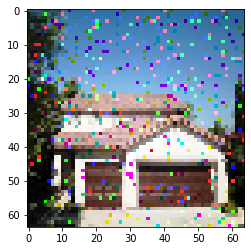

In [ ]:
plt.imshow(random_noise(new_image[7],mode='s&p',clip=True))

In [ ]:
#generateNoise
new_image2=[]
new_data2=[]
new_output2=[]
for i in range(train_image.shape[0]):
  new_image2.append(random_noise(new_image[i],mode='s&p',clip=True))
  new_data2.append(train_data[i])
  new_output2.append(train_output[i])

In [ ]:
#merge
train_image=np.concatenate((new_image,new_image2))
train_data=np.concatenate((new_data,new_data2))
train_output=np.concatenate((new_output,new_output2))

In [ ]:
del(new_image)
del(new_image2)
del(new_data)
del(new_data2)
del(new_output)
del(new_output2)

# Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=1)
mc = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_loss',verbose=1,save_best_only=True)

# Convolution neural network building (finding the best model)

## By normalizing the price

In [ ]:
#normalizing output(price)
scaler=MinMaxScaler()
output2=scaler.fit_transform(output.reshape(-1,1))
train_output2=output2[:9000]
valid_output2=output2[9000:11000]
test_output2=output2[11000:]
new_output=[]
for i in range(train_output2.shape[0]):
  new_output.append(train_output2[i])
train_output2=np.concatenate((train_output2,new_output))

In [ ]:
def build_model():
  input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
  input_model2= Input(shape=train_data.shape[1], name ="input2_layer")

  model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
  model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
  model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv1_3_3')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
  model1 = AveragePooling2D((2, 2),name = 'AvgPool1_1')(model1)
  model1 = Flatten(name = 'Flatten1')(model1)


  merged = Concatenate()([model1, input_model2])
  # neural network
  merged = Dense(units = 512, activation = 'relu')(merged)
  merged = BatchNormalization()(merged)
  merged = Dropout(rate = 0.4)(merged)
  merged = Dense(units = 256, activation = 'relu')(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(units = 128, activation = 'relu')(merged)
  merged = BatchNormalization()(merged)
  merged = Dropout(rate = 0.2)(merged)
  merged = Dense(units = 32, activation = 'relu')(merged)
  merged = BatchNormalization()(merged)
  output = Dense(units = 1, activation = 'sigmoid')(merged)

  model = Model(inputs= [input_model1,input_model2], outputs=[output])

  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.001), loss='mse')

In [ ]:
history = model.fit(x=[train_image,train_data],y=train_output2,steps_per_epoch=128,epochs= 5,validation_data= ([valid_image,valid_data],valid_output2),verbose=1,callbacks=[es , mc])

Epoch 1/5
128/128 [==============================] - ETA: 0s - loss: 0.1590
Epoch 00001: val_loss improved from inf to 0.04325, saving model to best_weights.hdf5
128/128 [==============================] - 506s 4s/step - loss: 0.1590 - val_loss: 0.0433
Epoch 2/5
128/128 [==============================] - ETA: 0s - loss: 0.1537
Epoch 00002: val_loss did not improve from 0.04325
128/128 [==============================] - 506s 4s/step - loss: 0.1537 - val_loss: 0.0580
Epoch 00002: early stopping


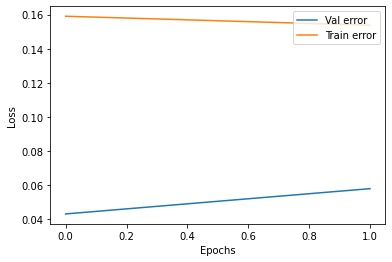

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

In [ ]:
y_pred = model.predict([valid_image,valid_data])
print(y_pred)
print(valid_output2)

[[0.14201283]
 [0.19732496]
 [0.16395691]
 ...
 [0.30028945]
 [0.20568454]
 [0.34244347]]
[[0.11634349]
 [0.10138504]
 [0.08531856]
 ...
 [0.8054    ]
 [0.80609418]
 [0.93074792]]


In [ ]:
maxPrice=max(output)
minPrice=min(output)

In [ ]:
realOutput=(valid_output2*(maxPrice-minPrice))+minPrice
predictedOutput=(y_pred*(maxPrice-minPrice))+minPrice
print(realOutput)
print(predictedOutput)

[[ 405000.]
 [ 378000.]
 [ 349000.]
 ...
 [1648747.]
 [1650000.]
 [1875000.]]
[[451333.16636086]
 [551171.55537009]
 [490942.22322106]
 ...
 [737022.4609971 ]
 [566260.59949398]
 [813110.45646667]]


In [ ]:
diff = predictedOutput.flatten() - realOutput
percentDiff = (diff / realOutput) * 100
absPercentDiff = np.abs(percentDiff)
meanPercentDiff = np.mean(absPercentDiff)
meanDiff=abs(np.mean(diff))
print('error percentage mean: '+str(meanPercentDiff))
print('error mean: '+str(meanDiff)+' dollars')

error percentage mean: 32.7429692764113
error mean: 242808.48591939217 dollars


In [ ]:
model.save_weights("MNIST_weights.h5")
model.save("MNIST_model.h5")

mean percent error is 33 percent and mean error is 243000 dollars which means the accuracy is low
we should not have normalized the price:

## Without normalizing the price:

In [ ]:
def build_model():
  input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
  input_model2= Input(shape=train_data.shape[1], name ="input2_layer")

  model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
  model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
  model1 = Conv2D(128,(1,1), activation='relu' ,padding='same',name = 'Conv1_3_3')(model1)
  model1 = Flatten(name = 'Flatten1')(model1)


  merged = Concatenate()([model1, input_model2])
  # neural network
  merged = Dense(units = 512, activation = 'relu')(merged)
  merged = Dropout(rate = 0.4)(merged)
  merged = Dense(units = 256, activation = 'relu')(merged)
  merged = Dense(units = 128, activation = 'relu')(merged)
  merged = Dropout(rate = 0.2)(merged)
  merged = Dense(units = 32, activation = 'relu')(merged)
  output = Dense(units = 1, activation = 'linear')(merged)

  model = Model(inputs= [input_model1,input_model2], outputs=[output])

  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_percentage_error')

In [ ]:
history = model.fit(x=[train_image,train_data],y=train_output,steps_per_epoch=128,epochs= 5,validation_data= ([valid_image,valid_data],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/5
128/128 [==============================] - ETA: 0s - loss: 48.0833
Epoch 00001: val_loss improved from inf to 36.45050, saving model to best_weights.hdf5
128/128 [==============================] - 624s 5s/step - loss: 48.0833 - val_loss: 36.4505
Epoch 2/5
128/128 [==============================] - ETA: 0s - loss: 43.8505
Epoch 00002: val_loss improved from 36.45050 to 32.16875, saving model to best_weights.hdf5
128/128 [==============================] - 622s 5s/step - loss: 43.8505 - val_loss: 32.1688
Epoch 3/5
128/128 [==============================] - ETA: 0s - loss: 43.9680
Epoch 00003: val_loss did not improve from 32.16875
128/128 [==============================] - 624s 5s/step - loss: 43.9680 - val_loss: 42.6317
Epoch 00003: early stopping


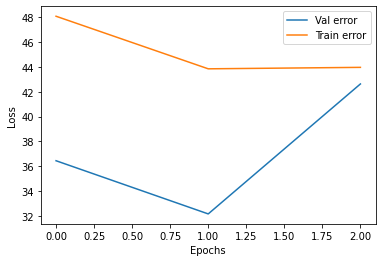

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

In [ ]:
y_pred = model.predict([valid_image,valid_data])
print(y_pred)
print(valid_output)

[[245508.33]
 [258322.53]
 [391391.28]
 ...
 [386697.03]
 [419710.88]
 [339299.75]]
[ 405000  378000  349000 ... 1648747 1650000 1875000]


In [ ]:
realOutput=(valid_output)
predictedOutput=(y_pred)


In [ ]:
diff = predictedOutput.flatten() - realOutput
percentDiff = (diff / realOutput) * 100
absPercentDiff = np.abs(percentDiff)
meanPercentDiff = np.mean(absPercentDiff)
meanDiff=abs(np.mean(diff))
print('error percentage mean: '+str(meanPercentDiff))
print('error mean: '+str(meanDiff)+' dollars')

error percentage mean: 42.631746777536364
error mean: 376829.2931835938 dollars


the model did not improve

## By adding the result of the convolutional neural network to the column of our neural netWork

In [ ]:
def build_model():
  input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
 # input_model2= Input(shape=train_data.shape[1], name ="input2_layer")

  model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
  model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
  model1 = Conv2D(64,(3,3), activation='relu',name = 'Conv1_3_3')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
  model1 = Conv2D(64,(3,3), activation='relu', padding='same',name= 'Conv1_4_3')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_4')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
  model1 = Conv2D(128,(1,1), activation='relu' ,padding='same',name = 'Conv1_5_1')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_5')(model1)
  model1 = Flatten(name = 'Flatten1')(model1)
  model1 = Dense(units = 2, activation = 'relu')(model1)
  output = BatchNormalization()(model1)
  model = Model(inputs= [input_model1], outputs=[output])
  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000000001), loss='mean_absolute_error')

In [ ]:
history = model.fit(x=train_image,y=train_output,epochs= 5,validation_data= ([valid_image],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/5
563/563 [==============================] - ETA: 0s - loss: 677725.6250
Epoch 00001: val_loss did not improve from 32.16875
563/563 [==============================] - 617s 1s/step - loss: 677725.6250 - val_loss: 743575.5625
Epoch 2/5
563/563 [==============================] - ETA: 0s - loss: 677725.3125
Epoch 00002: val_loss did not improve from 32.16875
563/563 [==============================] - 618s 1s/step - loss: 677725.3125 - val_loss: 743575.3750
Epoch 3/5
563/563 [==============================] - ETA: 0s - loss: 677725.8125
Epoch 00003: val_loss did not improve from 32.16875
563/563 [==============================] - 614s 1s/step - loss: 677725.8125 - val_loss: 743575.4375
Epoch 00003: early stopping


In [ ]:
y_pred_valid = model.predict(valid_image)
print(y_pred_valid)

[[ 0.2651418  -0.6897761 ]
 [ 0.60350007 -0.6897761 ]
 [-0.2777298  -0.6897761 ]
 ...
 [-0.81635445 -0.6897761 ]
 [-0.81635445 -0.6897761 ]
 [ 1.3552103  -0.6897761 ]]


In [ ]:
y_pred_train = model.predict(train_image)
print(y_pred_train)

[[-0.81635445 -0.6897761 ]
 [-0.81635445 -0.6897761 ]
 [ 0.8161754   0.14957577]
 ...
 [-0.81635445 -0.6897761 ]
 [-0.81635445 -0.39913103]
 [ 1.8407488   0.5955259 ]]


In [ ]:
scaler=MinMaxScaler()
y_pred_train=scaler.fit_transform(y_pred_train)
y_pred_valid=scaler.fit_transform(y_pred_valid)

In [ ]:
train_data2=np.hstack((train_data,y_pred_train))
valid_data2=np.hstack((valid_data,y_pred_valid))

In [ ]:
def build_model():
  #input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
  input_model2= Input(shape=train_data2.shape[1], name ="input2_layer")

  # neural network
  merged = Dense(units = 2000, activation = 'relu')(input_model2)
  merged = Dense(units = 1256, activation = 'relu')(merged)
  merged = Dense(units = 800, activation = 'relu')(merged)
  merged = Dropout(rate = 0.2)(merged)
  merged = Dense(units = 500, activation = 'relu')(merged)
  merged = Dense(units = 300, activation = 'relu')(merged)
  merged = Dense(units = 100, activation = 'relu')(merged)
  merged = Dense(units = 50, activation = 'relu')(merged)
  merged = Dense(units = 5, activation = 'relu')(merged)
  output = Dense(units = 1, activation = 'linear')(merged)
  model = Model(inputs= [input_model2], outputs=[output])
  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005,decay=0.0001), loss='mean_absolute_percentage_error')

In [ ]:
history = model.fit(x=train_data2,y=train_output,epochs= 100,validation_data= ([valid_data2],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/100
562/563 [============================>.] - ETA: 0s - loss: 62.8428
Epoch 00001: val_loss did not improve from 23.17730
563/563 [==============================] - 32s 58ms/step - loss: 62.8158 - val_loss: 29.1002
Epoch 2/100
562/563 [============================>.] - ETA: 0s - loss: 27.4257
Epoch 00002: val_loss did not improve from 23.17730
563/563 [==============================] - 32s 58ms/step - loss: 27.4218 - val_loss: 24.0938
Epoch 3/100
563/563 [==============================] - ETA: 0s - loss: 21.5618
Epoch 00003: val_loss did not improve from 23.17730
563/563 [==============================] - 33s 58ms/step - loss: 21.5618 - val_loss: 24.3026
Epoch 00003: early stopping


In [ ]:
model2=build_model()

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00002,decay=0.0001), loss='mean_absolute_percentage_error')

In [ ]:
history2 = model2.fit(x=train_data2,y=train_output,epochs= 100,validation_data= ([valid_data2],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/100
563/563 [==============================] - ETA: 0s - loss: 99.9374
Epoch 00001: val_loss did not improve from 23.17730
563/563 [==============================] - 33s 59ms/step - loss: 99.9374 - val_loss: 99.1155
Epoch 2/100
562/563 [============================>.] - ETA: 0s - loss: 54.1363
Epoch 00002: val_loss did not improve from 23.17730
563/563 [==============================] - 33s 59ms/step - loss: 54.1164 - val_loss: 32.9780
Epoch 3/100
563/563 [==============================] - ETA: 0s - loss: 35.1974
Epoch 00003: val_loss did not improve from 23.17730
563/563 [==============================] - 34s 60ms/step - loss: 35.1974 - val_loss: 30.5082
Epoch 4/100
563/563 [==============================] - ETA: 0s - loss: 31.6577
Epoch 00004: val_loss did not improve from 23.17730
563/563 [==============================] - 34s 60ms/step - loss: 31.6577 - val_loss: 28.2876
Epoch 5/100
562/563 [============================>.] - ETA: 0s - loss: 28.8395
Epoch 00005: val_loss did

In [ ]:
y_pred = model2.predict(valid_data2)
print(y_pred)
print(valid_output)

[[496061.1 ]
 [388081.9 ]
 [231017.95]
 ...
 [805626.4 ]
 [510030.16]
 [728597.5 ]]
[ 405000  378000  349000 ... 1648747 1650000 1875000]


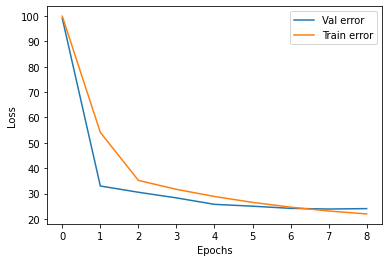

In [ ]:
val_loss = history2.history['val_loss']
loss = history2.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

In [ ]:
model.save_weights("MNIST_weights3.h5")
model.save("MNIST_model3.h5")

In [ ]:
realOutput=(valid_output)
predictedOutput=(y_pred)


In [ ]:
diff = predictedOutput.flatten() - realOutput
percentDiff = (diff / realOutput) * 100
absPercentDiff = np.abs(percentDiff)
meanPercentDiff = np.mean(absPercentDiff)
meanDiff=abs(np.mean(diff))
print('error percentage mean: '+str(meanPercentDiff))
print('error mean: '+str(meanDiff)+' dollars')

error percentage mean: 24.057583417845656
error mean: 196785.979671875 dollars


mean percent error is 24 percent and mean error is 196786 which means the accuracy got better.

## Trying a different preprocessing method for features

In [ ]:
input_data.head()

,street,sqft,masterbath,bed__1,bed__2,bed__3,bed__4,bed__5,bed__6,bed__7,bed__8,bed__9,bed__10,bed__11,bed__12,bath__0,bath__1,bath__2,bath__3,bath__4,bath__5,bath__6,bath__7,bath__8,bath__11,bath__13,bath__36,n_city__0,n_city__1,n_city__2,n_city__3,n_city__4,n_city__5,n_city__6,n_city__7,n_city__8,n_city__9,n_city__10,n_city__11,n_city__12,...,n_city__375,n_city__376,n_city__377,n_city__378,n_city__379,n_city__380,n_city__381,n_city__382,n_city__383,n_city__384,n_city__385,n_city__386,n_city__387,n_city__388,n_city__389,n_city__390,n_city__391,n_city__392,n_city__393,n_city__394,n_city__395,n_city__396,n_city__397,n_city__398,n_city__399,n_city__400,n_city__401,n_city__402,n_city__403,n_city__404,n_city__405,n_city__406,n_city__407,n_city__408,n_city__409,n_city__410,n_city__411,n_city__412,n_city__413,n_city__414
0,1317 Van Buren Avenue,1560,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,124 C Street W,713,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2304 Clark Road,800,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,755 Brawley Avenue,1082,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2207 R Carrillo Court,2547,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
t=0
new_foot=[]
for i in input_data['sqft']:
  if (i<1000):
    new_foot.append(1)
    t+=1
  elif (i<1200):
    new_foot.append(2)
    t+=1
  elif (i<1400):
    new_foot.append(3)
    t+=1
  elif (i<1550):
    new_foot.append(4)
    t+=1
  elif (i<1750):
    new_foot.append(5)
    t+=1
  elif (i<1800):
    new_foot.append(6)
    t+=1

  elif (i<2200):
    new_foot.append(7)
    t+=1

  elif (i<2600):
    new_foot.append(8)
    t+=1
  elif (i<3200):
    new_foot.append(9)
    t+=1
  else:
    new_foot.append(10)
    t+=1


In [ ]:
input_data['new_foot']=new_foot

In [ ]:
input_data=(pd.concat([input_data,pd.get_dummies(input_data.new_foot,prefix='ft')],axis=1)).drop(['new_foot'],axis=1)
input_data=input_data.drop('sqft',axis=1)

In [ ]:
input_data

,street,masterbath,bed__1,bed__2,bed__3,bed__4,bed__5,bed__6,bed__7,bed__8,bed__9,bed__10,bed__11,bed__12,bath__0,bath__1,bath__2,bath__3,bath__4,bath__5,bath__6,bath__7,bath__8,bath__11,bath__13,bath__36,n_city__0,n_city__1,n_city__2,n_city__3,n_city__4,n_city__5,n_city__6,n_city__7,n_city__8,n_city__9,n_city__10,n_city__11,n_city__12,n_city__13,...,n_city__385,n_city__386,n_city__387,n_city__388,n_city__389,n_city__390,n_city__391,n_city__392,n_city__393,n_city__394,n_city__395,n_city__396,n_city__397,n_city__398,n_city__399,n_city__400,n_city__401,n_city__402,n_city__403,n_city__404,n_city__405,n_city__406,n_city__407,n_city__408,n_city__409,n_city__410,n_city__411,n_city__412,n_city__413,n_city__414,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10
0,1317 Van Buren Avenue,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,124 C Street W,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2304 Clark Road,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,755 Brawley Avenue,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2207 R Carrillo Court,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,4156 Sterlingview Drive,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15470,4355 Avenida Prado,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15471,12717 Koenigstein Rd Road,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15472,36 Kunkle Street,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
input_data.shape

(15463, 451)

In [ ]:
new_street=[]
new_zipCode=[]
ignored_indices=[]
k=0
for i in input_data['street']:
  for j in range(len(i)):
    if (i[j]==' '):
      try:
        new_zipCode.append(int(i[:j]))
        new_street.append((i[j+1:]).lower())
      except:
        if (i=='Address not provided'):
          ignored_indices.append(k)
        else:
          haveHyphen=False
          for q in range(len(i)):
            if (i[q]=='-'):
              new_zipCode.append(int(i[:q]))
              haveHyphen=True

            if (i[q]==' ' and haveHyphen):
              new_street.append(i[q+1:].lower())
              break
          if (not haveHyphen):
            ignored_indices.append(k)
      break
  k+=1

In [ ]:
input_data=input_data.drop(ignored_indices,axis=0)
input_data=input_data.drop(['street'],axis=1)

In [ ]:
input_data['zip_code']=new_zipCode
input_data['address']=new_street

In [ ]:
input_data

,masterbath,bed__1,bed__2,bed__3,bed__4,bed__5,bed__6,bed__7,bed__8,bed__9,bed__10,bed__11,bed__12,bath__0,bath__1,bath__2,bath__3,bath__4,bath__5,bath__6,bath__7,bath__8,bath__11,bath__13,bath__36,n_city__0,n_city__1,n_city__2,n_city__3,n_city__4,n_city__5,n_city__6,n_city__7,n_city__8,n_city__9,n_city__10,n_city__11,n_city__12,n_city__13,n_city__14,...,n_city__387,n_city__388,n_city__389,n_city__390,n_city__391,n_city__392,n_city__393,n_city__394,n_city__395,n_city__396,n_city__397,n_city__398,n_city__399,n_city__400,n_city__401,n_city__402,n_city__403,n_city__404,n_city__405,n_city__406,n_city__407,n_city__408,n_city__409,n_city__410,n_city__411,n_city__412,n_city__413,n_city__414,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,zip_code,address
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1317,van buren avenue
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,124,c street w
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2304,clark road
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,755,brawley avenue
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2207,r carrillo court
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4156,sterlingview drive
15470,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4355,avenida prado
15471,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12717,koenigstein rd road
15472,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,36,kunkle street


In [ ]:
inputData=input_data.values

In [ ]:
labelencoder_X_1 = LabelEncoder()
inputData[:, -1] = labelencoder_X_1.fit_transform(inputData[:, -1])

In [ ]:
scaler=MinMaxScaler()
inputData=scaler.fit_transform(inputData)

In [ ]:
print(inputData)
print(output)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.77467670e-03 8.82027381e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.26165460e-04 1.22536169e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.53506872e-02 1.89241674e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.47285980e-02 4.61112729e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.39854488e-04 4.61792407e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  3.03948938e-02 3.00611710e-01]]
[201900 228500 273950 ... 920000 997000 975000]


In [ ]:
input=[]
i=0
with zipfile.ZipFile("/gdrive/My Drive/Proj2_data/data2/pics.zip", 'r') as zip:
  for info in zip.infolist():
    if(info.filename=='pics/'):
      continue
    ifile = zip.open(info)
    img=mpimg.imread(ifile)
    if (img.shape[2]!=4):
      img=cv2.resize(img,(64,64))
      input.append(img)
    i+=1

In [ ]:
input_image=np.array(np.delete(input,ignored_indices,axis=0))

In [ ]:
output=np.delete(output,ignored_indices,axis=0)

In [ ]:
print(input_image.shape)
print(inputData.shape)
print(output.shape)

(15437, 64, 64, 3)
(15437, 452)
(15437,)


In [ ]:
train_image=input_image[:9000,:]
valid_image=input_image[9000:11000,:]
test_image=input_image[11000:,:]
train_data=inputData[:9000]
valid_data=inputData[9000:11000]
test_data=inputData[11000:]
train_output=output[:9000]
valid_output=output[9000:11000]
test_output=output[11000:]

In [ ]:
test_data.shape

(4437, 452)

### Augmentation

In [ ]:
def HE(img):
    img_adapteq = exposure.equalize_hist(img)
    return img_adapteq

In [ ]:
#Histogram equalizing
new_image=[]
new_data=[]
new_output=[]
for i in range(train_image.shape[0]):
  new_image.append(HE(train_image[i]))
  new_data.append(train_data[i])
  new_output.append(train_output[i])


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [ ]:
#generateNoise
new_image2=[]
new_data2=[]
new_output2=[]
for i in range(train_image.shape[0]):
  new_image2.append(random_noise(new_image[i],mode='s&p',clip=True))
  new_data2.append(train_data[i])
  new_output2.append(train_output[i])

In [ ]:
#merge
train_image=np.concatenate((new_image,new_image2))
train_data=np.concatenate((new_data,new_data2))
train_output=np.concatenate((new_output,new_output2))

In [ ]:
del(new_image)
del(new_image2)
del(new_data)
del(new_data2)
del(new_output)
del(new_output2)

### Training

In [ ]:
def build_model():
  input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
 # input_model2= Input(shape=train_data.shape[1], name ="input2_layer")

  model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
  model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
  model1 = Conv2D(64,(3,3), activation='relu',name = 'Conv1_3_3')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
  model1 = Conv2D(64,(3,3), activation='relu', padding='same',name= 'Conv1_4_3')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_4')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
  model1 = Conv2D(128,(1,1), activation='relu' ,padding='same',name = 'Conv1_5_1')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_5')(model1)
  model1 = Flatten(name = 'Flatten1')(model1)
  model1 = Dense(units = 30, activation = 'relu')(model1)
  output = BatchNormalization()(model1)
  model1 = Dense(units = 1, activation = 'relu')(model1)
  output = BatchNormalization()(model1)
  model = Model(inputs= [input_model1], outputs=[output])
  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000000001), loss='mse')

In [ ]:
history = model.fit(x=train_image,y=train_output,epochs= 5,validation_data= ([valid_image],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/5
563/563 [==============================] - ETA: 0s - loss: 615907065856.0000
Epoch 00001: val_loss did not improve from 23.17730
563/563 [==============================] - 640s 1s/step - loss: 615907065856.0000 - val_loss: 687806742528.0000
Epoch 2/5
563/563 [==============================] - ETA: 0s - loss: 615907065856.0000
Epoch 00002: val_loss did not improve from 23.17730
563/563 [==============================] - 629s 1s/step - loss: 615907065856.0000 - val_loss: 687535095808.0000
Epoch 3/5
563/563 [==============================] - ETA: 0s - loss: 615907459072.0000
Epoch 00003: val_loss did not improve from 23.17730
563/563 [==============================] - 628s 1s/step - loss: 615907459072.0000 - val_loss: 687512682496.0000
Epoch 4/5
563/563 [==============================] - ETA: 0s - loss: 615907196928.0000
Epoch 00004: val_loss did not improve from 23.17730
563/563 [==============================] - 631s 1s/step - loss: 615907196928.0000 - val_loss: 687517138944.0

In [ ]:
y_pred_train = model.predict(train_image)
print(y_pred_train)

[[-0.17382711]
 [-0.5845885 ]
 [-0.5845885 ]
 ...
 [-0.5845885 ]
 [-0.39550626]
 [ 0.02296478]]


In [ ]:
y_pred_valid = model.predict(valid_image)
print(y_pred_valid)

[[1624.0773 ]
 [ 188.72534]
 [ 795.08295]
 ...
 [1678.4774 ]
 [1375.377  ]
 [  79.52116]]


In [ ]:
train_data2=np.hstack((train_data,y_pred_train))
valid_data2=np.hstack((valid_data,y_pred_valid))

In [ ]:
train_data2.shape

(18000, 453)

In [ ]:
def build_model():
  #input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
  input_model2= Input(shape=train_data2.shape[1], name ="input2_layer")

  # neural network

  merged = Dense(units = 1556, activation = 'relu')(input_model2)
  merged = Dense(units = 900, activation = 'relu')(merged)
  merged = Dropout(rate = 0.4)(merged)
  merged = Dense(units = 400, activation = 'relu')(merged)
  merged = Dense(units = 100, activation = 'relu')(merged)
  merged = Dense(units = 50, activation = 'relu')(merged)
  merged = Dense(units = 5, activation = 'relu')(merged)
  output = Dense(units = 1, activation = 'linear')(merged)
  model = Model(inputs= [input_model2], outputs=[output])
  return model

In [ ]:
model=build_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000001), loss='mean_absolute_percentage_error')

In [ ]:
history = model.fit(x=train_data2,y=train_output,epochs= 100,validation_data= ([valid_data2],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/100
563/563 [==============================] - ETA: 0s - loss: 100.0000
Epoch 00001: val_loss did not improve from 23.17730
563/563 [==============================] - 17s 30ms/step - loss: 100.0000 - val_loss: 99.9993
Epoch 2/100
563/563 [==============================] - ETA: 0s - loss: 100.0000
Epoch 00002: val_loss did not improve from 23.17730
563/563 [==============================] - 17s 30ms/step - loss: 100.0000 - val_loss: 99.9978
Epoch 3/100
563/563 [==============================] - ETA: 0s - loss: 100.0000
Epoch 00003: val_loss did not improve from 23.17730
563/563 [==============================] - 16s 29ms/step - loss: 100.0000 - val_loss: 99.9953
Epoch 4/100
562/563 [============================>.] - ETA: 0s - loss: 100.0000
Epoch 00004: val_loss did not improve from 23.17730
563/563 [==============================] - 17s 29ms/step - loss: 100.0000 - val_loss: 99.9912
Epoch 5/100
563/563 [==============================] - ETA: 0s - loss: 100.0000
Epoch 00005: val

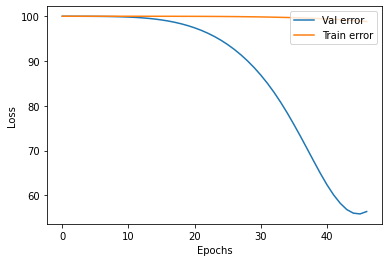

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

In [ ]:
y_pred = model.predict(valid_data2)
print(y_pred)
print(valid_output)

[[1272897.9 ]
 [ 150524.02]
 [ 624558.75]
 ...
 [1315255.5 ]
 [1077846.2 ]
 [  65152.89]]
[ 350000  399900  354000 ... 1499000 1695000 1867500]


In [ ]:
model.save_weights("MNIST_weights3.h5")
model.save("MNIST_model3.h5")

In [ ]:
realOutput=(valid_output)
predictedOutput=(y_pred)


In [ ]:
diff = predictedOutput.flatten() - realOutput
percentDiff = (diff / realOutput) * 100
absPercentDiff = np.abs(percentDiff)
meanPercentDiff = np.mean(absPercentDiff)
meanDiff=abs(np.mean(diff))
print('error percentage mean: '+str(meanPercentDiff))
print('error mean: '+str(meanDiff)+' dollars')

error percentage mean: 56.36661615311922
error mean: 288381.4086004639 dollars


mean percent error is 56 percent and mean error is 288381

# Predicting the output of the test data

we trained the model by the input in shape processed in preprocessing and augmentation sections.Thus, we load the input again

In [ ]:
def build_model():
  input_model1 = Input((train_image.shape[1],train_image.shape[2],train_image.shape[3]),name = 'input1_layer')
 # input_model2= Input(shape=train_data.shape[1], name ="input2_layer")

  model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
  model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
  model1 = Conv2D(64,(3,3), activation='relu',name = 'Conv1_3_3')(input_model1)
  model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
  model1 = Conv2D(64,(3,3), activation='relu', padding='same',name= 'Conv1_4_3')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_4')(model1)
  model1 = MaxPooling2D((2, 2),name = 'MaxPool2')(model1)
  model1 = Conv2D(128,(1,1), activation='relu' ,padding='same',name = 'Conv1_5_1')(model1)
  model1 = BatchNormalization(name = 'Bnorm1_5')(model1)
  model1 = Flatten(name = 'Flatten1')(model1)
  model1 = Dense(units = 2, activation = 'relu')(model1)
  output = BatchNormalization()(model1)
  model = Model(inputs= [input_model1], outputs=[output])
  return model

In [ ]:
model1=build_model()

In [ ]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000000001), loss='mean_absolute_error')

In [ ]:
history = model1.fit(x=train_image,y=train_output,epochs= 5,validation_data= ([valid_image],valid_output),verbose=1,callbacks=[es , mc])

Epoch 1/5
563/563 [==============================] - ETA: 0s - loss: 677379.5000
Epoch 00001: val_loss did not improve from 23.17730
563/563 [==============================] - 612s 1s/step - loss: 677379.5000 - val_loss: 750021.6875
Epoch 2/5
563/563 [==============================] - ETA: 0s - loss: 677379.5000
Epoch 00002: val_loss did not improve from 23.17730
563/563 [==============================] - 605s 1s/step - loss: 677379.5000 - val_loss: 750021.1875
Epoch 3/5
563/563 [==============================] - ETA: 0s - loss: 677379.1250
Epoch 00003: val_loss did not improve from 23.17730
563/563 [==============================] - 606s 1s/step - loss: 677379.1250 - val_loss: 750019.9375
Epoch 4/5
563/563 [==============================] - ETA: 0s - loss: 677379.1250
Epoch 00004: val_loss did not improve from 23.17730
563/563 [==============================] - 606s 1s/step - loss: 677379.1250 - val_loss: 750021.4375
Epoch 00004: early stopping


In [ ]:
y_pred_test = model1.predict(test_image)
print(y_pred_test)

[[ 0.75901306  0.9251209 ]
 [-0.61686635 -0.66397685]
 [-0.61686635  2.1518266 ]
 ...
 [-0.61686635 -0.66397685]
 [-0.17658332  3.987797  ]
 [ 0.03144819 -0.66397685]]


In [ ]:
scaler=MinMaxScaler()
y_pred_test=scaler.fit_transform(y_pred_test)

In [ ]:
test_data2=np.hstack((test_data,y_pred_test))

In [ ]:
test_data2.shape

(4463, 444)

In [ ]:
model=keras.models.load_model('MNIST_model3.h5')

In [ ]:
y_pred = model.predict(test_data2)
print(y_pred)

[[497943.03]
 [738989.6 ]
 [799872.3 ]
 ...
 [389698.22]
 [432185.1 ]
 [325667.  ]]


In [ ]:
realOutput=(test_output)
predictedOutput=(y_pred)


In [ ]:
diff = predictedOutput.flatten() - realOutput
percentDiff = (diff / realOutput) * 100
absPercentDiff = np.abs(percentDiff)
meanPercentDiff = np.mean(absPercentDiff)
meanDiff=abs(np.mean(diff))
print('error percentage mean: '+str(meanPercentDiff))
print('error mean: '+str(meanDiff)+' dollars')

error percentage mean: 33.99271367956925
error mean: 274685.1154212413 dollars
